In [1]:
# global variables

SAVE_ELEMENTS = False

#paths
BPI_PATH = 'BPI Challenge 2017.xes'
ACTIVITIES_PATH = 'activities.xml'

# log processing
MIN_SPEAKING_TIME = 60
SPEAK_THRESHOLD = 600
DAY_DIFFERENCE = 20

# verfification
VERITYTA_PATH = ""
QUERY_DIRECTORY = "queries/"

# transition system
SEQUENCE_HISTORY = 3

In [2]:
import numpy as np
import random
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import matplotlib.pyplot as plt

import copy
from collections import Counter

import pygraphviz as pgv
import json

import pm4py

from collections import Counter
import subprocess

In [3]:
# Load the log
from pm4py.objects.log.importer.xes import importer as xes_importer
log_application = xes_importer.apply(BPI_PATH)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

# Investigate implications in the log
Certain events always surround other events or are always followed by other events.
We discover some connections to reduce the size of later modells.

In [4]:
# A_complete is always preceeded by "W_call after offers"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Complete" in pos["concept:name"]:
            if "W_Call after offers" not in trace[pos_index-1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [5]:
# "W_call after offers" has always "A_complete"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "W_call after offers" in pos["concept:name"]:
            index_inner = pos_index+1
            while trace[index_inner]["concept:name"] == "W_call after offers":
                index_inner += 1
            if "A_complete" not in trace[index_inner]["concept:name"]:
                for e in trace[index_inner-5:index_inner+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [6]:
# A_Incomplete is always surrounded by "W_Call incomplete files"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Incomplete" in pos["concept:name"]:
            if "W_Call incomplete files" not in trace[pos_index-1]["concept:name"] and "W_Call incomplete files" not in trace[pos_index+1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [7]:
#Create offer is always followed by "Created"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [8]:
# number of calls
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [9]:
def contains(trace, element):
    for event in trace:
        if event['concept:name']==element:
            return True

# Preprocessing of the log
Several operations are performed:
- The log is split into two parts at the concept drift
- Call events ('W_Call incomplete files' and 'W_Call after offers') are accumulated and discretized by time. 
- - With a runtime of 60 - 600 sec. is the event considered as "SHORT"
- - between 10min and 4h as "LONG"
- - exceeding 4h as "SUPER LONG"
- Other workflow events are ignored
- Cancellation events after A_Pending are ignored
- 'O_Create Offer' is tagged (enumerted to consider how many offers were created)
- s_0 and terminal states are appended

In [10]:
log = copy.deepcopy(log_application)
log_before = pm4py.filter_time_range(log, "2011-03-09 00:00:00", "2016-06-30 23:59:59", mode='traces_contained')
log_after = pm4py.filter_time_range(log, "2016-08-01 00:00:00", "2018-03-09 00:00:00", mode='traces_contained')

In [11]:
# The log is filtered based on variations.
def filter_log(log):
    perc = 2/len(log)
    return pm4py.filter_variants_by_coverage_percentage(log, perc)

filtered_log_before = filter_log(log_before)
filtered_log_after = filter_log(log_after)

In [12]:
def construct_log(log):
    terminal_states = ['A_Cancelled COMPANY', 'A_Cancelled CUSTOMER', 'A_Pending', 'TIMEOUT']#, 'A_Denied']
    to_merge = ['W_Call incomplete files', 'W_Call after offers', 'W_Complete application', 'W_Validate application']
    log_activities = []
    for trace in log:
        current_trace = [trace[0]]
        for i in range(1,len(trace)):
            pos = trace[i]
            if "W_Call" in trace[i]['concept:name']:
                # search for closing event
                if pos['lifecycle:transition'] in ["start", "resume"]:
                    for inner_index in range(i+1, len(trace)):
                        inner_pos = trace[inner_index]
                        if pos['concept:name'] == inner_pos['concept:name']:
                            if inner_pos['lifecycle:transition'] in ["suspend", "complete"]:                 
                                duration = (inner_pos['time:timestamp']-pos['time:timestamp']).total_seconds()
                                if duration > MIN_SPEAKING_TIME:
                                    if pos['concept:name'] in current_trace[-1]["concept:name"]:
                                        current_trace[-1]["duration"] += duration
                                    else:
                                        current_trace.append(pos)
                                        current_trace[-1]['duration'] = duration
                                    if current_trace[-1]["duration"] < SPEAK_THRESHOLD:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SHORT"
                                    elif current_trace[-1]["duration"] < 14400:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" LONG"
                                    else:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SUPER LONG"
                            break
            if "W_" in trace[i]['concept:name']:
                continue # skip other workflow events
            if trace[i]['concept:name'] in ["A_Created", "A_Complete", "A_Incomplete"]:
                continue # skip trivial elements
            if trace[i]['concept:name'] == "A_Cancelled": #differentiate between user_abort and timeout
                current_trace.append(pos)
                if (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).days >= DAY_DIFFERENCE:
                    current_trace[-1]['concept:name'] = "TIMEOUT"
                else:
                    current_trace[-1]['concept:name'] += " CUSTOMER"
                continue
            if "O_Created" == trace[i]['concept:name']:
                continue # merge create and created
            if trace[i]['concept:name'] in terminal_states:
                current_trace.append(pos)
            else:
                if trace[i]['concept:name'] in to_merge and trace[i]['concept:name'] == trace[i-1]['concept:name']:
                    continue
                else:
                    current_trace.append(pos)
        if "A_Pending" in [pos['concept:name'] for pos in current_trace]:
            if "O_Cancelled" in [pos['concept:name'] for pos in current_trace]:
                for pos1 in current_trace:
                    if 'O_Cancelled' in pos1['concept:name']:
                        current_trace.remove(pos1)
        intersection = [i for i in trace if i['concept:name'] in terminal_states]
        for state in terminal_states:
            indices = [i for i, x in enumerate(current_trace) if x['concept:name'] == state]
            if indices:
                current_trace = current_trace[:indices[0]+1]
        if intersection:
            log_activities.append(current_trace)
    
    return log_activities

filtered_log_before = construct_log(filtered_log_before)
filtered_log_after = construct_log(filtered_log_after)

In [13]:
# process log to iterate created offers and differentiate between positive and negative traces
MAX_INDEX = 100
def process_log(log):
    
    for trace in log:
        #trace.insert(0,{'concept:name': "start"})
        isPositive = False
        if contains(trace, 'A_Pending'):
            isPositive = True
        trace.insert(0,{'concept:name': "start"})
        if isPositive:
            trace.append({'concept:name': "positive"})
        else:
            trace.append({'concept:name': "negative"})
    
    to_extend = ["O_Create Offer"]
    for name in to_extend:
        element = 0
        for trace in log:
            indices = [i for i, x in enumerate(trace) if x['concept:name'] == name]
            for i in indices:
                count_indices = [j for j in indices if j < i]
                index = MAX_INDEX if len(count_indices) > MAX_INDEX else len(count_indices)
                trace[i]['concept:name'] += " "+str(index)

process_log(filtered_log_before)
process_log(filtered_log_after)

In [14]:
# distribuion over positive and negative traces in log
def plot_negative_positive(log):
    outcome = ["positive" if "positive" in [i['concept:name'] for i in trace] else "negative" for trace in log]
    print(Counter(outcome))
plot_negative_positive(filtered_log_before)
plot_negative_positive(filtered_log_after)

Counter({'negative': 2907, 'positive': 2608})
Counter({'negative': 3699, 'positive': 3290})


# Building the transition system
The processes log is used to generate a transition system.
The transition system is extended with actors and then with weights, resulting in a user journey game.

In [15]:
# several abstractions are supported: Sequence (hist) and multiset (ms)
# transforms log into user-journey log
def ms(trace):
    multiset = {}
    for pos in trace:
        if pos['concept:name'] not in multiset:
            multiset[pos['concept:name']] = 1
        else:
            multiset[pos['concept:name']] += 1
    return json.dumps(multiset, sort_keys=True).encode() # use json encodings for multisets

def hist(trace): 
    hist = str(trace[0]['concept:name'])
    for pos in trace[1:]:
        hist += " - " + str(pos['concept:name']) # construct history
    return hist

def transition_system(log, history = 1, actors = {}):
    edges = []
    edge_counter = {}
    controll = {}
    action = {}
    edge_mapping = {}
    for trace_index in range(len(log)):
        trace = log[trace_index]
        s = "start"
        assert(trace[0]['concept:name']=="start")
        for pos_index in range(1,len(trace)):
            pos = trace[pos_index]
            activity = pos['concept:name']
            controllable = True
            for key in actors:
                if key in activity:
                    controllable = actors[key]=='company'
            #t = ms(trace[max(0,pos_index-history+1):pos_index+1])
            t = hist(trace[max(0,pos_index-history+1):pos_index+1])
            e = (s,t)
            controll[e] = controllable
            action[e] = activity
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
                edge_mapping[e] = [trace_index]
            else:
                edge_counter[e] = edge_counter[e]+1
                edge_mapping[e].append(trace_index)
            s = t
    g = nx.DiGraph()
    for e in edges:
        g.add_edge(e[0], e[1])
    to_remove = [] # to remove selve-loops
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        # set properties
        g[e[0]][e[1]]['controllable'] = controll[e]
        g[e[0]][e[1]]['action'] = action[e]
        if not controll[e]:
            g[e[0]][e[1]]['prob_weight'] = len(edge_mapping[e])

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    
    return g, edge_mapping

with open(ACTIVITIES_PATH) as f:
    data = f.read()
actors = json.loads(data)

system_before, edge_mapping_before = transition_system(filtered_log_before, history = SEQUENCE_HISTORY, actors = actors)
system_after, edge_mapping_after = transition_system(filtered_log_after, history = SEQUENCE_HISTORY, actors = actors)

In [16]:
# compute weights
def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i]['concept:name'] == s and trace[i+1]['concept:name'] == t:
            return True
    return False

def weight(trace):
    return 1 if any("positive" in pos['concept:name'] for pos in trace) else -1

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log, edge_mapping):
    distr = {1.0: 0 , -1.0 : 0}
    assert((s,t) in edge_mapping)
    for trace_index in edge_mapping[(s,t)]:
        w = weight(log[trace_index])
        distr[w] += 1 #
    return distr[1], distr[-1]

def compute_edge_cost(g, traces, edge_mapping):
    edge_cost = {}
    counter = 1
    for s in g.nodes:
        counter +=1
        for t in g[s]:

            
            p1, p2 = distribution(s,t,traces, edge_mapping)
            w = 1 if p1 >= p2 else -1

            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)

            scaling = 20
            entro = entropy(wp1, wp2)

            edge_cost[(s,t)] = (((1-entro) * w) -0.21 )*scaling

    return edge_cost

edge_cost_before = compute_edge_cost(system_before, filtered_log_before, edge_mapping_before)
edge_cost_after = compute_edge_cost(system_after, filtered_log_after, edge_mapping_after)

In [17]:
def draw_dfg(g, name, layout = "sfdp"):
    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])

    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
    
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

def color_graph(g, green = 4, red = -4):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > green:
            g[e[0]][e[1]]['color'] ="green"
        elif g[e[0]][e[1]]['label'] < red:
            g[e[0]][e[1]]['color'] ="red"
        else:
            g[e[0]][e[1]]['color'] ="gray"
    
    return g

g_before = annotate_graph(system_before, edge_cost_before)
g_before_colored = color_graph(g_before)
if SAVE_ELEMENTS:
    draw_dfg(g_before, "graph_weight_before.ps", "dot")
    draw_dfg(g_before_colored, 'colored_before.ps', "dot")

g_after = annotate_graph(system_after, edge_cost_after)
g_after_colored = color_graph(g_after)
if SAVE_ELEMENTS:
    draw_dfg(g_after, "graph_weight_after.ps", "dot")
    draw_dfg(g_after_colored, 'colored_after.ps', "dot")

In [18]:
# Investigate cycles in transition system
def print_cycles(g):
    for c in nx.simple_cycles(g):
        count = 0
        c.append(c[0])
        for i in range(len(c)-1):
            count += g[c[i]][c[i+1]]['label']
        print(len(c))
        print("count", count)
print("##### first event log #####")
print_cycles(g_before)
print("")
print("##### second eent log #####")
print_cycles(g_after)

##### first event log #####
10
count -177.79999999999998
6
count -117.41000000000001
10
count -177.79999999999998
5
count -96.8
5
count 63.2

##### second eent log #####
5
count -96.8
3
count 31.6
5
count 63.2


In [19]:
def investigate_calls(log):
    for element in ["W_Call after offers", "W_Call incomplete files"]:
        # claim: calls are not really helpful...
        outcomes_call = {"pos": 0, "neg": 0}
        outcomes_no_call = {"pos": 0, "neg": 0}
        outcomes_short = {"pos": 0, "neg": 0}
        outcomes_long = {"pos": 0, "neg": 0}
        outcomes_super = {"pos": 0, "neg": 0}
        for trace in log:
            call = [element in pos["concept:name"] for pos in trace]
            short = [element+" SHORT" in pos["concept:name"] for pos in trace]
            long = [element+" LONG" in pos["concept:name"] for pos in trace]
            super_long = [element+" SUPER LONG" in pos["concept:name"] for pos in trace]
            result = ["positive" in pos["concept:name"] for pos in trace]
            if sum(call) > 0:
                if sum(result) > 0:
                    outcomes_call["pos"] += 1
                    if sum(short) > 0:
                        outcomes_short["pos"] += 1
                    elif sum(long) > 0:
                        outcomes_long["pos"] += 1
                    elif sum(super_long) > 0:
                         outcomes_super["pos"] += 1
                else:
                    outcomes_call["neg"] += 1
                    if sum(short) > 0:
                        outcomes_short["neg"] += 1
                    elif sum(long) > 0:
                        outcomes_long["neg"] += 1
                    elif sum(super_long) > 0:
                         outcomes_super["neg"] += 1
            else:
                if sum(result) > 0:
                    outcomes_no_call["pos"] += 1
                else:
                    outcomes_no_call["neg"] += 1
        
        print(element)
        print("no call")
        print(outcomes_no_call)
        print(outcomes_no_call["pos"]/(outcomes_no_call["neg"]+outcomes_no_call["pos"]))
        print("call")
        print(outcomes_call)
        print(outcomes_call["pos"]/(outcomes_call["neg"]+outcomes_call["pos"]))
        print("short")
        print(outcomes_short)
        print(outcomes_short["pos"]/(outcomes_short["neg"]+outcomes_short["pos"]))
        print("long")
        print(outcomes_long)
        print(outcomes_long["pos"]/(outcomes_long["neg"]+outcomes_long["pos"]))
        print("super long")
        print(outcomes_super)
        print(outcomes_super["pos"]/(outcomes_super["neg"]+outcomes_super["pos"]))
        print()
        # calls not really impact
        # after drift are super long calls 3% more effective (0.34)
    
investigate_calls(filtered_log_before)
print("########")
investigate_calls(filtered_log_after)

W_Call after offers
no call
{'pos': 396, 'neg': 431}
0.4788391777509069
call
{'pos': 2212, 'neg': 2476}
0.4718430034129693
short
{'pos': 2023, 'neg': 2252}
0.47321637426900587
long
{'pos': 182, 'neg': 209}
0.46547314578005117
super long
{'pos': 7, 'neg': 15}
0.3181818181818182

W_Call incomplete files
no call
{'pos': 1500, 'neg': 2885}
0.34207525655644244
call
{'pos': 1108, 'neg': 22}
0.9805309734513274
short
{'pos': 938, 'neg': 18}
0.9811715481171548
long
{'pos': 169, 'neg': 4}
0.976878612716763
super long
{'pos': 1, 'neg': 0}
1.0

########
W_Call after offers
no call
{'pos': 506, 'neg': 550}
0.4791666666666667
call
{'pos': 2784, 'neg': 3149}
0.46923984493510873
short
{'pos': 2580, 'neg': 2909}
0.47003097103297503
long
{'pos': 190, 'neg': 213}
0.47146401985111663
super long
{'pos': 14, 'neg': 27}
0.34146341463414637

W_Call incomplete files
no call
{'pos': 1505, 'neg': 3679}
0.29031635802469136
call
{'pos': 1785, 'neg': 20}
0.9889196675900277
short
{'pos': 1604, 'neg': 16}
0.990123456

In [20]:
def compute_bounds(g, start, depth):
    lower_bounds = {}
    upper_bounds = {}
    queue = [(start,0)]
    counter = 0
    while(queue and counter < depth):
        counter += 1
        s, previous_gas = queue.pop(0)
        for t in g[s]:
            current_gas = previous_gas + g[s][t]['label']
            if t not in lower_bounds:
                lower_bounds[t] = current_gas
            else:
                lower_bounds[t] = min(lower_bounds[t], current_gas)
            if t not in upper_bounds:
                upper_bounds[t] = current_gas
            else:
                upper_bounds[t] = max(upper_bounds[t], current_gas)
            queue.append((t, current_gas))
    return lower_bounds, upper_bounds
lower_bounds_before, upper_bounds_before = compute_bounds(g_before_colored, "start", 200)
lower_bounds_after, upper_bounds_after = compute_bounds(g_after_colored, "start", 200)

short -96.58000000000001
long -27.159999999999993
very -17.470000000000002
added

short -136.58
long -67.16
very -57.47
added

short -136.58
long -67.16
very -57.47
added

short -40.88
long -45.22

short -136.58
long -67.16

short -80.81
long -80.81

short -80.81
long -80.81

short -6.299999999999995
long -5.91
very -1.6700000000000017
added

short -105.01
long -105.01
very -81.67
added

short -105.01
long -105.01
very -81.67
added

short -50.53
long -58.83

short -45.080000000000005
long -69.42

short -84.74

short -84.74
long -79.74

short -84.74

short -84.74
long -79.74

short -96.58000000000001
long -67.16

short 30.67
long 33.34

short 30.67
long 33.34

short -9.33
long -6.66

short -38.419999999999995

short -44.739999999999995

['O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Valida

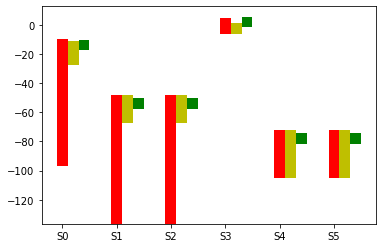

6
88.38000000000001
O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT
71.21000000000001
O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT
16.179999999999993
O_Sent (mail and online) - W_Call after offers SUPER LONG - TIMEOUT
71.21000000000001
O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER
18.370000000000005
O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER
7.310000000000002
O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Cancelled CUSTOMER
87.16000000000001
O_Sent (mail and online) - W_Call after offers SHORT - A_Validating
16.54
O_Sent (mail and online) - W_Call after offers LONG - A_Validating
8.359999999999996
O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Validating
7.310000000000002
O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 1
7.309999999999999
O_Sent (mail and online) - W_Call after offers LONG - O_Create Offer 1
7.310000000000002
O_Sent (mail and

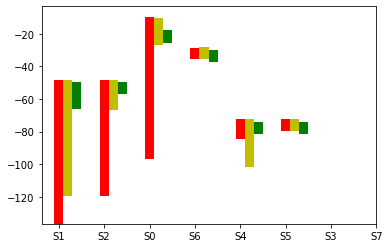

8


In [21]:
def call_responses(lower_bounds, upper_bounds):
    responses_lower = []
    responses_upper = []
    states = []
    names = []
    for element in lower_bounds:
        current_lower = []
        current_upper = []
        current_names = []
        found = False
        if "SHORT" in element.split("-")[-2] or "SHORT" in element.split("-")[0]:
            short = element
            long = element.replace("SHORT", "LONG")
            very = element.replace("SHORT", "SUPER LONG")
            found = True
        """
        elif "LONG" in element.split("-")[-2] or "LONG" in element.split("-")[0]:
            long = element
            short = element.replace("LONG", "SHORT")
            very = element.replace("LONG", "SUPER LONG")
            found = True
        """

        if not found:
            continue
        if short in lower_bounds:
            print("short", lower_bounds[short])
            current_lower.append(lower_bounds[short])
            current_upper.append(upper_bounds[short])
            current_names.append(short)
        else:
            current_lower.append(None)
            current_upper.append(None)
            current_names.append(None)
        if long in lower_bounds:
            print("long", lower_bounds[long])
            current_lower.append(lower_bounds[long])
            current_upper.append(upper_bounds[long])
            current_names.append(long)
        else:
            current_lower.append(None)
            current_upper.append(None)
            current_names.append(None)
        if very in lower_bounds:
            print("very", lower_bounds[very])
            current_lower.append(lower_bounds[very])
            current_upper.append(upper_bounds[very])
            current_names.append(very)
        else:
            current_lower.append(None)
            current_upper.append(None)
            current_names.append(None)
        if current_lower.count(None)==0:
            states.append(short)
            responses_lower.append(current_lower)
            responses_upper.append(current_upper)
            names.append(current_names)
            print("added")
        print("")
    print(states)
    print(len(states))
    return responses_lower, responses_upper, names

def plot_bounds(lower, upper, names, plot_name):
    colors = ["r", "y", "g"]
    for element in range(len(call_lower_before)):
        for index in range(len(call_lower_before[element])):
            if call_upper_before[element][index] == None:
                assert(False)
                continue
            height = upper[element][index] - lower[element][index]
            print(height)
            plt.bar(element+index*0.2, height = height, width = 0.2, color = colors[index], bottom = lower[element][index])
            print(names[element][index])
    plt.savefig(plot_name)
    plt.xticks(np.arange(len(lower)),labels = [name_dict[n[0]] for n in names])
    plt.show()
    print(len(names))

call_lower_before, call_upper_before, names_before = call_responses(lower_bounds_before, upper_bounds_before)
print("######")
call_lower_after, call_upper_after, names_after = call_responses(lower_bounds_after, upper_bounds_after)

name_dict = {}
count = 0
for n in names_before:
    if n[0] not in name_dict:
        name_dict[n[0]] = "S"+str(count)
        count += 1
for n in names_after:
    if n[0] not in name_dict:
        name_dict[n[0]] = "S"+str(count)
        count += 1

plot_bounds(call_lower_before, call_upper_before, names_before, "calls_before.png")
plot_bounds(call_lower_after, call_upper_after, names_after, "calls_after.png")

#plt.bar([1,2,3,4], height=[2,2.5,5,3], bottom=[0,-1,1,2])


# Unrolling operation
The UPPAAL model checking suite is used to verify claims about the user journey game.
An acyclic model is required by the model checker for termination.
A breath-first search and loop counting is applied to build an acyclic model.

In [22]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True
    
# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        if debug:
            print(len(G_gen.nodes), len(queue))
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G[s_original][t_original]):
                    G_gen[s][t]['controllable'] = G[s_original][t_original]['controllable']
                if('prob_weight' in G[s_original][t_original]):
                    G_gen[s][t]['prob_weight'] = G[s_original][t_original]['prob_weight']

    print("Graph was unrolled")
    return G_gen

## Unrolling Example
A graph is unrolled by an breath-first search starting in $s_0$. Every state not laying on 

Graph was unrolled


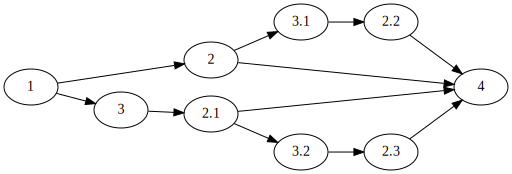

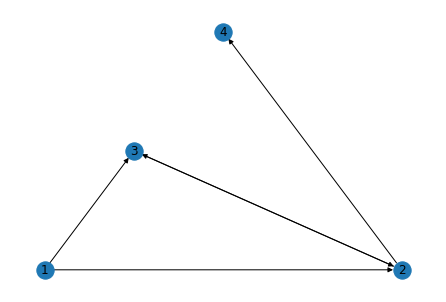

In [23]:
G=nx.DiGraph()
G.add_nodes_from(["1","2","3","4"])
G.add_edges_from([("1","2"),("1","3"),("2","3"),("3", "2"), ("2", "4")])
target = "4"

pos = nx.planar_layout(G)
nx.draw(G, with_labels = True, pos = pos)

k = 1
start = "1"

G_gen = unroll(G, start,[target],1)
A = to_agraph(G_gen)
A.layout('dot', args='-Grankdir=LR')
A.draw('gen.png')
A

In [24]:
# unrolling of user journey game
target = [s for s in g_before_colored.nodes if "positive" in s or "negative" in s]
g_before_unroll = unroll(g_before_colored, "start", target, 1)
target = [s for s in g_after_colored.nodes if "positive" in s or "negative" in s]
g_after_unroll = unroll(g_after_colored, "start", target, 1)

Graph was unrolled
Graph was unrolled


In [25]:
# assert that only one positive endpoint exists
def final_sound(g):
    # positive final states (should be one)
    positives = []
    for s in g.nodes:
        if "positive" in s:
            positives.append(s)
    assert(len(positives) == 1)
    
final_sound(g_before_unroll)
final_sound(g_after_unroll)

In [29]:
# construction of uppaal model (write model into upaal file)
def to_uppaal(g, name, layout = "sfdp"):
    f = open("/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/"+name, "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog=layout, args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int e = 0;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('\n'+'bool negative = false;')
    f.write('\n'+'bool positive = false;')
    f.write('\n'+'int final_gas = -1;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    branch = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
        f.write('\n')

    i = max(ids.values())+1
    
    for s in pos:
        for e in g.edges(s):
            if "controllable" in g[e[0]][e[1]]:
                if not g[e[0]][e[1]]["controllable"]:
                    f.write('<branchpoint id="id'+str(i)+'" x="'+str(int(pos[s][0])+20)+'" y="'+str(int(pos[s][1])+20)+'"/>')
                    f.write("\n")
                    branch[s]=i
                    i+=1
                    break # print branchpoint only once per state
                    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    
    for s in pos:
        for e in g.edges(s):
            if "controllable" in g[e[0]][e[1]]:
                if not g[e[0]][e[1]]["controllable"]:
                    f.write('<transition id="'+str(i)+'" controllable="false" >')
                    i = i+1
                    f.write('<source ref="id'+str(ids[s])+'"/>')
                    f.write('<target ref="id'+str(branch[s])+'"/>')
                    f.write('<label kind="assignment" x="'+str(int(pos[s][0]))+'" y="'+str(int(pos[s][1]))+'">')
                    f.write(' steps += 1')
                    f.write(',\n'+ 'x = 0')
                    f.write('</label>')
                    f.write('</transition>')
                    f.write("\n")
                    break # print branchpoint-edge only once per state
    
    max_id = max(ids.values())
    ids["outOfGas"] = max_id+1
    
    for e in g.edges:
        if "label" in g[e[0]][e[1]] and "controllable" in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]["controllable"]:
                print_edge(f, branch[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)
            else:
                print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)
        else:
            if "label" not in g[e[0]][e[1]]:
                if "controllable" not in g[e[0]][e[1]]:
                    print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], 0, True, e, g)

    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    print("all written to", f.name)

def print_location(f, location_id, x, y, name):
    name = str(name)
    name = name.replace('"', '-')
    name = name.replace('{', '')
    name = name.replace('}', '')
    name = name.replace("'", '-')
    name = name.replace("_", '')
    name = name.replace("(", '')
    name = name.replace(")", '')
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y)+20)+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y)-30)+'">')
    if "positive" not in name and "negative" not in name and "outOfGas" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, w, controllable, e, g, guard = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
    
    if controllable and False:
        f.write('<label kind="guard" x="'+str(int(x))+'" y="'+str(int(y))+'"> x&gt;= 1')
        f.write('</label>')
        
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write(' steps += 1')
    f.write(',\n'+ 'x = 0')
    if "positive" in str(e[1]):
        f.write(',\n'+ 'positive = true')
        f.write(',\n'+ 'final_gas = e +'+str(int(round(w))))
    elif "negative" in str(e[1]):
        f.write(',\n'+ 'negative = true')
        f.write(',\n'+ 'final_gas = e + '+str(int(round(w))))
        
    f.write(',\n'+'e = e + '+str(int(round(w))))
    f.write('</label>')
    
    if not controllable:
        f.write('<label kind="probability" x="'+str(int(x)-20)+'" y="'+str(int(y)-20)+'">'+str(int(g[e[0]][e[1]]['prob_weight'])))
        f.write('</label>')
    f.write('</transition>')

if SAVE_ELEMENTS:
    to_uppaal(g_before_colored, "bpi2017_before.xml", layout = "dot")
    to_uppaal(g_before_unroll, "bpi2017_before_unroll.xml")

    to_uppaal(g_after_colored, "bpi2017_after.xml", layout = "dot")
    to_uppaal(g_after_unroll, "bpi2017_after_unroll.xml")

# Decision boundary computation
Function to create decision boundary plot, Fig. 4.
The decision boundary contains the states where the future outcome is decided.
There exists no chance to recover from the decision, the outcome is by then decided.

In [30]:
def remove_undecision(g):
    g = copy.deepcopy(g)
    for s in g:
        uncontrollable = False
        controllable = False
        for e in g.edges(s):
            print(e)
            attr = g[e[0]][e[1]]
            if attr["controllable"]:
                controllable = True
            else:
                uncontrollable = True
        to_remove = []
        if controllable and uncontrollable:
            for e in g.edges(s):
                attr = g[e[0]][e[1]]
                if attr["controllable"]:
                    to_remove.append(e)
        for e in to_remove:
            g.remove_edge(e[0],e[1])
    return g
#g_decideable = remove_undecision(g)
#draw_dfg(g_decideable, 'decideable.ps', "dot")
#to_uppaal(g_decideable, "decideable.xml")

# Computes mapping R from alg. 1
def query(g):
    # partial graph implications, per activity
    results = {}
    intervals = {}
    min_gas = {}
    counter = 0
    for a in g.nodes:
        print("counter", counter, "current action", a)
        counter += 1
        states = [a]

        sub_nodes = set()
        for s in states:
            sub_nodes.update(set(list(nx.descendants(g, s))))
            sub_nodes.add(s)
        if len(sub_nodes) > 100: # execute only on nodes with less than 100 descendants for better performance
            continue
        subgraph = nx.subgraph(g, sub_nodes)
        subgraph = nx.DiGraph(subgraph)

        # add start node to subgraph
        start_nodes = []
        for n in subgraph.nodes:
            if subgraph.in_degree(n) == 0:
                start_nodes.append(n)
        for n in start_nodes:
            subgraph.add_edge("start", n)
            subgraph["start"][n]["controllable"] = True
            subgraph["start"][n]["label"] = 0
        # if initial node lies on cycle, per default set as start node
        if "start" not in subgraph.nodes:
            for n in states:
                subgraph.add_edge("start", n)
                subgraph["start"][n]["controllable"] = True
                subgraph["start"][n]["label"] = 0

        target = [s for s in subgraph.nodes if "positive" in s or "negative" in s]
        subgraph_unrolled = unroll(subgraph, "start", target, 1)
        positives = []
        for s in subgraph_unrolled.nodes:
            if "positive" in s:
                positives.append(s)
        assert(len(positives) <= 1)
        to_uppaal(subgraph_unrolled, "bpi2017subgraph.xml")
        out = subprocess.Popen(["/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/queries/guaranteed.q"], stdout=subprocess.PIPE)
        result = "is satisfied" in str(out.communicate()[0])
        results[a] = result

        decideable = remove_undecision(subgraph)
        target = [s for s in decideable.nodes if "positive" in s or "negative" in s]
        decideable_unrolled = unroll(decideable, "start", target, 1)
        positives = []
        for s in decideable_unrolled.nodes:
            if "positive" in s:
                positives.append(s)
        assert(len(positives) <= 1)
        to_uppaal(decideable_unrolled, "bpi2017subgraph.xml")
        out = subprocess.Popen(["/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/queries/probability.q", "-E", "0.001"], stdout=subprocess.PIPE)
        s = str(out.communicate()[0]).split("formula 3")[1].split("Pr(<>")[1]
        interval = s[s.find("["):s.find("]")+1]
        print("interval", interval)
        intervals[a] = interval

        out = subprocess.Popen(["/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml", "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/queries/min_gas.q"], stdout=subprocess.PIPE)
        s = str(out.communicate()[0]).split("formula 3")[1].split("Values in")[1]
        interval = s[s.find("["):s.find("]")+1]
        print("min gas", interval)
        min_gas[a] = interval
        
    return results, intervals, min_gas

results_before, intervals_before, min_gas_before = query(g_before_colored)
results_after, intervals_after, min_gas_after = query(g_after_colored)

counter 0 current action start
counter 1 current action start - A_Create Application
counter 2 current action start - A_Create Application - A_Submitted
counter 3 current action A_Create Application - A_Submitted - A_Concept
counter 4 current action A_Submitted - A_Concept - A_Accepted
counter 5 current action A_Concept - A_Accepted - O_Create Offer 0
counter 6 current action A_Accepted - O_Create Offer 0 - O_Sent (mail and online)
counter 7 current action O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SH

('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT')
('O_Returned - W_Call incomplete files SHORT - O_Accepted', 'W_Call incomplete files SHORT - O_Accepted - A_Pending')
('O_S

interval [0.000107365,0.00152054]
min gas [-48,-35]
counter 10 current action A_Validating - O_Returned - W_Call incomplete files SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_

interval [0,0.000999738]
min gas [-21,-18]
counter 16 current action O_Sent (mail and online) - A_Validating - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
('A_Validating - W_Call incomplete 

('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT')
('O_Returned - W_Call incomplete files SHORT - O_Accepted', 'W_Call incomplete files SHORT - O_Accepted - A_Pending')
('O_R

min gas [-41,-38]
counter 20 current action A_Validating - O_Returned - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - W_Call incomple

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 24 current action W_Call incomplete files LONG - A_Validating - O_Accepted
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 25 current action O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TI

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

('O_Create Offer 1 - O_Sent (mail and online) - TIMEOUT', 'O_Sent (mail and online) - TIMEOUT - negative')
('start', 'O_Create Offer 1 - O_Sent (mail and online) - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 40 current action O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('start', 'O_Create Offer 1 - O_Sent (mail and online) - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 41 current action O_Create Offer 0 - O_Sent (mail and online) - O_Create Offer 1
Graph was unrolled
al

min gas [0,0]
counter 42 current action O_Sent (mail and online) - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplet

('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - O_Accepted', 'W_Call incomplete files SHORT - O_Accepted - A_Pending')
('start', 'O_Returned - W_Call incomplete files SHORT - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 44 current action W_Call incomplete files SHORT - O_Accepted - A_Pending
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'W_Call incomplete files SHORT - O_Accepted - A_Pending')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 45 current action O_Returned - W_Call incomplete files LONG - O_Accepted
G

min gas [-264,-192]
counter 48 current action O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete 

min gas [-79,-48]
counter 49 current action O_Create Offer 1 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incom

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

min gas [-66,-66]
counter 52 current action W_Call after offers SHORT - O_Create Offer 2 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
('A_Validating - W_Call incomplete files 

min gas [0,0]
counter 57 current action O_Sent (mail and online) - W_Call after offers LONG - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - A_Validating', 'O_Sent (mail and online) - A_Validating - O_Returned')
('O_Sent (mail and online) - O_Cancelled - TIMEOUT', 'O_Cancelled - TIMEOUT - negative')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-72,-48]
counter 59 current action start - A_Create Application - A_Concept
counter 60 current action A_Create Application - A_Concept - A_Accepted
counter 61 current action O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SUPER LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SUPER LONG', 'O_Sent (mail and online) - W_Call after offers SUPER LONG - TIMEOUT')
('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SUPER LONG', 'O_Sent (mail and online) - 

min gas [-55,-55]
counter 66 current action O_Sent (mail and online) - O_Create Offer 2 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 3 - O_Sent (mail and online) - TIMEOUT', 'O_Sent (mail and online) - TIMEOUT - negative')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('O_Create Offer 3 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files L

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-19,-16]
counter 68 current action O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - 

('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 

min gas [-48,-48]
counter 74 current action O_Cancelled - W_Call after offers SHORT - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Cancelled - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TIMEOUT - negative')
('start', 'O_Cancelled - W_Call after offers SHORT - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 75 current action O_Sent (mail and online) - O_Cancelled - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - O_Cancelled - TIMEOUT', 'O_Cancelled - TIMEOUT - negative')
('start', 'O_Sent (mail and online) - O_Cancelled - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,

min gas [-168,-96]
counter 78 current action O_Create Offer 0 - O_Cancelled - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LO

min gas [-144,-72]
counter 79 current action O_Cancelled - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files 

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

min gas [-96,-48]
counter 81 current action O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 82 current action O_Create Offer 1 - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and o

min gas [-24,-24]
counter 86 current action O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT')
('O_Returned -

interval [0.999,1]
min gas [0,0]
counter 89 current action W_Call incomplete files SHORT - A_Validating - W_Call incomplete files LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pen

interval [0,0.000999738]
min gas [-48,-48]
counter 97 current action O_Sent (online only) - W_Call after offers SHORT - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (online only) - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TIMEOUT - negative')
('start', 'O_Sent (online only) - W_Call after offers SHORT - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 98 current action O_Sent (online only) - W_Call after offers SHORT - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (online only) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (online only) - W_Call after offers SHORT - A_Cancelled CUSTOMER'

min gas [-56,-56]
counter 106 current action O_Create Offer 0 - O_Create Offer 1 - O_Create Offer 2
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUP

min gas [-168,-144]
counter 107 current action O_Create Offer 1 - O_Create Offer 2 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete

min gas [-120,-120]
counter 108 current action O_Create Offer 2 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call in

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER', 'O_Create Offer 0 - A_Cancelled CUSTOMER - negative')
('start', 'A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 111 current action O_Create Offer 0 - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Create Offer 0 - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 112 current action O_Create Offer 3 - O_Sent (mail and online) - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2

min gas [-120,-96]
counter 114 current action O_Create Offer 2 - O_Create Offer 3 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete 

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

('W_Call after offers SHORT - O_Cancelled - A_Cancelled CUSTOMER', 'O_Cancelled - A_Cancelled CUSTOMER - negative')
('start', 'W_Call after offers SHORT - O_Cancelled - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 119 current action O_Cancelled - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Cancelled - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 120 current action O_Create Offer 2 - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pend

min gas [-240,-168]
counter 123 current action O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT')
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - TIMEOUT')
('O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TIMEOUT - negative')
('O_Cancelled - O_Sent (mail and online) - TIMEOUT', 'O_Sent (mail and online) - TIMEOUT - negative')
('start', 'O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interv

min gas [-48,-48]
counter 131 current action O_Create Offer 1 - O_Sent (online only) - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Create Offer 1 - O_Sent (online only) - TIMEOUT', 'O_Sent (online only) - TIMEOUT - negative')
('start', 'O_Create Offer 1 - O_Sent (online only) - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 132 current action O_Sent (online only) - TIMEOUT - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Sent (online only) - TIMEOUT - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 133 current action W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only)
Graph was 

min gas [-216,-144]
counter 135 current action O_Cancelled - O_Cancelled - O_Create Offer 2
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG'

min gas [-144,-120]
counter 136 current action O_Cancelled - O_Create Offer 2 - O_Create Offer 3
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER 

min gas [-120,-96]
counter 137 current action O_Create Offer 1 - O_Sent (online only) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Returned - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('O_Sent (online only) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Create Offer 1 - O_Sent (online only) - A_Validating', 'O_Sent (online only) - A_Validating - O_Returned')
('start', 'O_Create Offer 1 - O_Sent (online only) - A_Validating')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 138 current action O_Sent (online only) - A_Validating - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Returned - O_Accepted - A_Pen

min gas [-144,-72]
counter 142 current action O_Sent (mail and online) - W_Call after offers LONG - O_Cancelled
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomple

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Validating')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files LONG')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SUPER LONG')
('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incompl

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call after offers SHORT - O_Cancelled - TIMEOUT', 'O_Cancelled - TIMEOUT - negative')
('start', 'W_Call after offers SHORT - O_Cancelled - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 145 current action W_Call after offers SHORT - O_Cancelled - O_Cancelled
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call after offers SHORT - O_Cancelled - O_Cancelled', 'O_Cancelled - O_Cancelled - A_Cancelled CUSTOMER')
('O_Cancelled - O_Cancelled - A_Cancelled CUSTOMER', 'O_Cancelled - A_Cancelled CUSTOMER - negative')
('start', 'W_Call after offers SHORT - O_Cancelled - O_Cancelled')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min ga

('O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TIMEOUT - negative')
('start', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 9 current action W_Call after offers SHORT - TIMEOUT - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'W_Call after offers SHORT - TIMEOUT - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 10 current action O_Create Offer 0 - O_Sent (mail and online) - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Create Offer 0 - O_Sent (mail and online) - TIMEOUT', 'O_Sent (mail and onlin

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]
counter 13 current action O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 14 current action W_Call after offers LONG - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
Graph was unro

interval [0.0732441,0.0752348]
min gas [-14,0]
counter 24 current action W_Call after offers SHORT - A_Validating - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Va

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Accepted - A_Pending - positive')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 28 current action O_Create Offer 0 - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files 

interval [0,0.000999738]
min gas [-36,-34]
counter 30 current action O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Cancelled - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('O_Create Offer 1 - O_Sent (mail and online) - O_Create Offer 2', 'O_Sent (mail and online) - O_Create Offer 2 - O_Sent (mail and online)')
('O_Returned - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
('O_Returned - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT')
('O_Returned - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call inc

interval [0,0.000999738]
min gas [-48,-48]
counter 31 current action W_Call after offers SHORT - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - A_Validating', 'O_Sent (mail and online) - A_Validating - O_Returned')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Se

interval [0,0.000999738]
min gas [-77,-48]
counter 32 current action O_Create Offer 1 - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - A_Validating', 'O_Sent (mail and online) - A_Validating - O_Returned')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplet

interval [0,0.000999738]
min gas [-48,-48]
counter 34 current action O_Returned - W_Call incomplete files SHORT - O_Accepted
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - O_Accepted', 'W_Call incomplete files SHORT - O_Accepted - A_Pending')
('start', 'O_Returned - W_Call incomplete files SHORT - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 35 current action W_Call incomplete files SHORT - O_Accepted - A_Pending
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'W_Call incomplete files SHORT - O_Accepted - A_

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 40 current action W_Call incomplete files SHORT - A_Validating - O_Accepted
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'W_Call incomplete files SHORT - A_Validating - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 41 current action A_Validating - O_Accepted - A_Pending
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'A_Validating - O_Accepted - A_

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 45 current action W_Call incomplete files LONG - A_Validating - O_Accepted
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('start', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0.999,1]
min gas [0,0]
counter 46 current action O_Sent (mail and online) - W_Call after offers LONG - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validati

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-6,-6]
counter 47 current action W_Call after offers LONG - A_Validating - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call 

interval [0,0.000999738]
min gas [-48,-48]
counter 49 current action O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Cancelled CUSTOMER', 'W_Call after offers SUPER LONG - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 50 current action W_Call after offers SUPER LONG - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'W_Call after offers SUPER LONG - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.2

interval [0,0.000999738]
min gas [-48,-32]
counter 53 current action A_Accepted - O_Create Offer 0 - O_Create Offer 1
counter 54 current action O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TIMEOUT - negative')
('O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT', 'W_Call after offers LONG - TIMEOUT - negative')
('O_Sent (mail and online) - W_Call after offers SHORT - A_Validating', 'W_Call after offers SHORT - A_Validating - O_Returned')
('O_Sent (mail and online) - W_Call afte

min gas [-79,-48]
counter 55 current action O_Create Offer 1 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Sent (mail and online) - W_Call after offers LONG - A_Cancelled CUSTOMER', 'W_Call after offers LONG - A_Cancelled CUSTOMER - negative')
('O_Returned - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - O_Accepted')
('O_Returned - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT')
('O_Returned - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files LONG')
('O_Returned - W_Call incomplete files LONG - A_Cancelled CUSTOMER', 'W_Call incomplete files LONG - A_Cancelled CUSTOMER - negative')


interval [0,0.000999738]
min gas [-55,-48]
counter 56 current action O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHO

min gas [-48,-48]
counter 57 current action O_Sent (mail and online) - O_Sent (mail and online) - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - O_Sent (mail and online) - TIMEOUT', 'O_Sent (mail and online) - TIMEOUT - negative')
('start', 'O_Sent (mail and online) - O_Sent (mail and online) - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 58 current action O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call inco

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]
counter 59 current action O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - O_Sent (mail and online) - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 60 current action O_Sent (mail and online) - O_Sent (mail and online) - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pendin

Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - O_Cancelled')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_V

interval [0,0.000999738]
min gas [-96,-48]
counter 64 current action O_Sent (mail and online) - W_Call after offers LONG - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - A_Validating', 'O_Sent (mail and online) - A_Validating - O_Returned')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sen

min gas [-100,-52]
counter 65 current action W_Call after offers LONG - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - A_Validating', 'O_Sent (mail and online) - A_Validating - O_Returned')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-96,-48]
counter 66 current action W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Returned - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('O_Create Offer 1 - O_Sent (online only) - TIMEOUT', 'O_Sent (online only) - TIMEOUT - negative')
('O_Sent (online only) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only)', 'O_Create Offer 1 - O_Sent (online only) - TIMEOUT')
('W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only)', 'O_Create Offer 1 - O_Sent (online only) - A_Cancelled CUSTOMER')
('W_Call after offers SHORT - O_Create Offer 1 - O

interval [0,0.000999738]
min gas [-48,-48]
counter 70 current action O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only)', 'O_Create Offer 1 - O_Sent (online only) - TIMEOUT')
('O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only)', 'O_Create Offer 1 - O_Sent (online only) - A_Cancelled CUSTOMER')
('O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only)', 'O_Create Offer 1 - O_Sent (online only) - A_Validating')
('O_Returned - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('O_Create Offer 1 - O_Sent (online only) - TIMEOUT', 'O_Sent (online only) - TIMEOUT - negative')
('O_Sent (online only) - A_Validating - O_Returned', 'A_Validating - O_Returned - O_Accepted')
('O_Create Of

interval [0.999,1]
min gas [0,0]
counter 75 current action A_Validating - W_Call incomplete files SHORT - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT', 'A_Validatin

interval [0.999,1]
min gas [0,0]
counter 81 current action O_Create Offer 1 - O_Sent (online only) - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Create Offer 1 - O_Sent (online only) - A_Cancelled CUSTOMER', 'O_Sent (online only) - A_Cancelled CUSTOMER - negative')
('start', 'O_Create Offer 1 - O_Sent (online only) - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 82 current action O_Sent (online only) - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Sent (online only) - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 83 cur

interval [0,0.000999738]
min gas [-52,-52]
counter 85 current action O_Create Offer 0 - O_Sent (online only) - W_Call after offers SHORT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files L

min gas [-24,-24]
counter 87 current action O_Create Offer 0 - O_Sent (online only) - W_Call after offers LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT')
('A_Validating - W_Call inc

interval [0,0.000999738]
min gas [-48,-48]
counter 91 current action O_Create Offer 0 - O_Create Offer 1 - O_Cancelled
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Cancelled - O_Sent (mail and online) - W_Call after offers LONG', 'O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT')
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - TIMEOUT')
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT')
('O_Create Offer 1 - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - W_Call after offers LONG')
('O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-26,-26]
counter 96 current action A_Validating - W_Call incomplete files SHORT - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete 

interval [0,0.000999738]
min gas [-22,-22]
counter 99 current action O_Cancelled - O_Sent (mail and online) - W_Call after offers LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT', 'W_Call after offers LONG - TIMEOUT - negative')
('O_Cancelled - O_Sent (mail and online) - W_Call after offers LONG', 'O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT')
('start', 'O_Cancelled - O_Sent (mail and online) - W_Call after offers LONG')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]
counter 100 current action O_Sent (mail and online) - W_Call after offers SUPER LONG - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers SUPER LONG - TIMEOUT', 'W

interval [0.999,1]
min gas [0,0]
counter 108 current action A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER', 'O_Create Offer 0 - A_Cancelled CUSTOMER - negative')
('start', 'A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 109 current action O_Create Offer 0 - A_Cancelled CUSTOMER - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Create Offer 0 - A_Cancelled CUSTOMER - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 110 current action A_Accepted - O_Create Offer

interval [0,0.000999738]
min gas [-144,-96]
counter 111 current action O_Create Offer 0 - O_Cancelled - O_Create Offer 1
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - O_Cancelled')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incompl

interval [0,0.000999738]
min gas [-120,-72]
counter 112 current action O_Cancelled - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - O_Cancelled')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call

interval [0,0.000999738]
min gas [-96,-48]
counter 113 current action O_Sent (mail and online) - W_Call after offers SHORT - O_Cancelled
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - O_Cancelled')
('O_Returned - W_Call incomplete files LONG - O_Accepted',

interval [0,0.000999738]
min gas [-72,-48]
counter 114 current action W_Call after offers SHORT - O_Cancelled - TIMEOUT
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call after offers SHORT - O_Cancelled - TIMEOUT', 'O_Cancelled - TIMEOUT - negative')
('start', 'W_Call after offers SHORT - O_Cancelled - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 115 current action O_Cancelled - TIMEOUT - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Cancelled - TIMEOUT - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 116 current action W_Call after offers SHORT - O_Cancelled - A_Cancelled CUSTOMER
Graph was unrolle

interval [0,0.000999738]
min gas [-144,-72]
counter 121 current action O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers SUPER LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incompl

('A_Accepted - O_Create Offer 0 - TIMEOUT', 'O_Create Offer 0 - TIMEOUT - negative')
('start', 'A_Accepted - O_Create Offer 0 - TIMEOUT')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 125 current action O_Create Offer 0 - TIMEOUT - negative
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('start', 'O_Create Offer 0 - TIMEOUT - negative')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [0,0]
counter 126 current action O_Sent (online only) - W_Call after offers SHORT - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_P

interval [0,0.000999738]
min gas [-52,-52]
counter 128 current action W_Call after offers SUPER LONG - O_Create Offer 1 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Create Offer 1 - O_Sent (mail and online) - A_Validating', 'O_Sent (mail and online) - A_Validating - O_Returned')
('W_Call after offers SUPER LONG - O_Create Offer 1 - O_Sent (mail and online)', 'O_Create Offer 1 - O_Sent (mail and online) - TIMEOUT')
('W_Call after offers SUPER LONG - O_Create Offer 1 - O_Sent (mail and online)', 'O_Create Offer 1 - O_Sent (mail and online) - A_Validating')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accept

interval [0.999,1]
min gas [0,0]
counter 132 current action A_Validating - W_Call incomplete files LONG - O_Returned
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call incomplete files LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - O_Accepted')
('W_Call incomplete files SHORT - A_Validating - W_Call incomplete files SHORT', 'A_Validating - W_Call incomplete files SHORT - A_Validating')
('W_Call incomplete files SHORT - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive'

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-32,-32]
counter 136 current action O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers LONG
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT', 'W_Call after offers LONG - TIMEOUT - negative')
('O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers LONG', 'O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT')
('start', 'O_Create Offer 1 - O_Sent (mail and online) - W_Call after offers LONG')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-48,-48]
counter 137 current action W_Call after offers SHORT - O_Create Offer 1 - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego

all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-144,-144]
counter 140 current action O_Create Offer 1 - O_Create Offer 2 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_A

min gas [-120,-120]
counter 141 current action O_Create Offer 2 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_

min gas [-96,-96]
counter 142 current action O_Sent (mail and online) - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER

min gas [-72,-72]
counter 143 current action O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 2
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('W_Call after offers SHORT - O_Create Offer 2 - O_Sent (mail and online)', 'O_Create Offer 2 - O_Sent (mail and online) - TIMEOUT')
('W_Call after offers SHORT - O_Create Offer 2 - O_Sent (mail and online)', 'O_Create Offer 2 - O_Sent (mail and online) - A_Cancelled CUSTOMER')
('O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 2', 'W_Call after offers SHORT - O_Create Offer 2 - O_Sent (mail and online)')
('O_Create Offer 2 - O_Sent (mail and online) - TIMEOUT', 'O_Sent (mail and online) - TIMEOUT - negative')
('O_Create Offer 2 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('start', 'O_Sent (mail and online) - W_Call after offers SHORT - O_Create Offer 2')
Graph was unrolled
a

min gas [-32,-32]
counter 149 current action O_Sent (mail and online) - O_Create Offer 2 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call incomplete files SHORT - A_Cancelled CUSTOMER - negative')
('W_Call incomplete files LONG - A_Validating - O_Accepted', 'A_Validating - O_Accepted - A_Pending')
('A_Validating - W_Call incomplete files LONG - A_Validating', 'W_Call incomplete files LONG - A_Validating - W_Call incomplete files SHORT')
('A_Validating - W_Cal

min gas [-20,-18]
counter 151 current action O_Create Offer 1 - O_Create Offer 2 - O_Cancelled
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT')
('O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER')
('O_Cancelled - O_Cancelled - O_Sent (mail and online)', 'O_Cancelled - O_Sent (mail and online) - W_Call after offers SHORT')
('O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('O_Create Offer 1 - O_Create Offer 2 - O_Cancelled', 'O_Create Offer 2 - O_Cancelled - O_Cancelled')
('O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TIMEOUT - negative')
('O_Create Offer 2 - 

min gas [-72,-72]
counter 155 current action O_Create Offer 2 - O_Sent (mail and online) - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Create Offer 2 - O_Sent (mail and online) - A_Cancelled CUSTOMER', 'O_Sent (mail and online) - A_Cancelled CUSTOMER - negative')
('start', 'O_Create Offer 2 - O_Sent (mail and online) - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 156 current action O_Sent (online only) - W_Call after offers LONG - A_Validating
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted'

min gas [-48,-48]
counter 159 current action O_Cancelled - W_Call after offers SHORT - A_Cancelled CUSTOMER
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Cancelled - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('start', 'O_Cancelled - W_Call after offers SHORT - A_Cancelled CUSTOMER')
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
interval [0,0.000999738]
min gas [-24,-24]
counter 160 current action O_Create Offer 0 - O_Create Offer 1 - O_Sent (online only)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('O_Sent (online only) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 'W_Call after offers SHORT - A_Cancelled CUSTOMER - negative')
('O_Sent (online only) - W_Call after offers SHORT - TIMEOUT', 'W_Call after offers SHORT - TI

min gas [-144,-144]
counter 165 current action O_Create Offer 2 - O_Create Offer 3 - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_Call inc

min gas [-120,-120]
counter 166 current action O_Create Offer 3 - O_Sent (mail and online) - O_Sent (mail and online)
Graph was unrolled
all written to /home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bpi2017subgraph.xml
('A_Validating - O_Returned - O_Accepted', 'O_Returned - O_Accepted - A_Pending')
('A_Validating - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('W_Call incomplete files SUPER LONG - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files LONG - O_Accepted', 'W_Call incomplete files LONG - O_Accepted - A_Pending')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - W_Call incomplete files SHORT')
('W_Call incomplete files SHORT - O_Returned - A_Validating', 'O_Returned - A_Validating - O_Accepted')
('W_Call incomplete files SHORT - O_Accepted - A_Pending', 'O_Accepted - A_Pending - positive')
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 'W_

min gas [-96,-96]


In [31]:
events_before = set([x['concept:name'] for trace in filtered_log_before for x in trace])
events_after = set([x['concept:name'] for trace in filtered_log_after for x in trace])
events = events_before.union(events_after)

events_short = {}
for e in events:
    numbers = [int(s) for s in e.split(" ") if s.isdigit()]
    if not numbers:
        events_short[e] = e[:3]
    else:
        assert(len(numbers)==1)
        events_short[e] = e[:3]+str(numbers[0])
    if "online only" in e:
        events_short[e] += ".o"
    if "mail and online" in e:
        events_short[e] += ".m+o"
    if "SHORT" in e:
        events_short[e] += ".s"
    if "SUPER LONG" in e:
        events_short[e] += ".sl"
    elif "LONG" in e:
        events_short[e] += ".s"
    print(e, events_short[e])
print(len(events_short), set([e for e in events_short[e]]))
print(events)
print(len(events_before), len(events_after))

A_Submitted A_S
O_Create Offer 0 O_C0
A_Concept A_C
W_Call incomplete files LONG W_C.s
W_Call after offers SUPER LONG W_C.sl
O_Returned O_R
O_Sent (mail and online) O_S.m+o
A_Validating A_V
negative neg
A_Create Application A_C
TIMEOUT TIM
O_Sent (online only) O_S.o
W_Call after offers LONG W_C.s
W_Call incomplete files SUPER LONG W_C.sl
W_Call incomplete files SHORT W_C.s
O_Accepted O_A
O_Cancelled O_C
W_Call after offers SHORT W_C.s
A_Pending A_P
A_Accepted A_A
O_Create Offer 3 O_C3
positive pos
O_Create Offer 2 O_C2
A_Cancelled CUSTOMER A_C
start sta
O_Create Offer 1 O_C1
26 {'1', '_', 'C', 'O'}
{'A_Submitted', 'O_Create Offer 0', 'A_Concept', 'W_Call incomplete files LONG', 'W_Call after offers SUPER LONG', 'O_Returned', 'O_Sent (mail and online)', 'A_Validating', 'negative', 'A_Create Application', 'TIMEOUT', 'O_Sent (online only)', 'W_Call after offers LONG', 'W_Call incomplete files SUPER LONG', 'W_Call incomplete files SHORT', 'O_Accepted', 'O_Cancelled', 'W_Call after offers S

In [32]:
print("before")
for s in g_before_colored:
    s = s.split("-")
    if "Call" in s[0] and "Call" in s[-1]:
        print(s)
        
print("")
for s in g_before_colored:
    s = s.split("-")
    if len(s) < 2:
        continue
    if "O_Returned" in s[1]:
        print(s)
        
print("after")        
for s in g_after_colored:
    s = s.split("-")
    if "Call" in s[0] and "Call" in s[-1]:
        print(s)

before
['W_Call incomplete files SHORT ', ' A_Validating ', ' W_Call incomplete files SHORT']
['W_Call incomplete files LONG ', ' A_Validating ', ' W_Call incomplete files SHORT']
['W_Call incomplete files SHORT ', ' A_Validating ', ' W_Call incomplete files LONG']

['A_Validating ', ' O_Returned ', ' W_Call incomplete files SHORT']
['A_Validating ', ' O_Returned ', ' A_Validating']
['A_Validating ', ' O_Returned ', ' W_Call incomplete files LONG']
['A_Validating ', ' O_Returned ', ' O_Accepted']
['A_Validating ', ' O_Returned ', ' A_Cancelled CUSTOMER']
['A_Validating ', ' O_Returned ', ' W_Call incomplete files SUPER LONG']
after
['W_Call incomplete files SHORT ', ' A_Validating ', ' W_Call incomplete files SHORT']
['W_Call incomplete files LONG ', ' A_Validating ', ' W_Call incomplete files SHORT']
['W_Call incomplete files SHORT ', ' A_Validating ', ' W_Call incomplete files LONG']
['W_Call after offers SHORT ', ' A_Validating ', ' W_Call incomplete files SHORT']
['W_Call incomplet

Nodes after the decision boundary are merged into "positive" and "negative" states.
1:1 connections in the graph are contracted.

In [50]:
# Computing nodes in decision boundary and generatig plot

def compute_labels(g1, g2):
    new_labels = {}
    new_labels_int = {}
    
    both_nodes = []
    for n in g1.nodes:
        if n not in both_nodes:
            both_nodes.append(n)
    for n in g2.nodes:
        if n not in both_nodes:
            both_nodes.append(n)
    
    #both_nodes = set(g1.nodes).union(set(g2.nodes))
    for n,i in zip(both_nodes, range(len(both_nodes))):
        h = [e.strip() for e in n.split("-")]
        h1 = events_short[h[0]]
        for e in h[1:]:
            h1 += " - "
            h1 += events_short[e]
        new_labels[n] = h1
        new_labels_int[n] = i

    new_labels.pop("start")
    #new_labels.pop("positive")
    #new_labels.pop("negative")
    
    new_labels_int.pop("start")
    #new_labels_int["positive"] = "pos"
    #new_labels_int["negative"] = "neg"
    return new_labels_int

def draw_dfg(g, name, results, intervals, labels, layout = "sfdp"):
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))
    g = copy.deepcopy(g)
    
    for s in results:
        pos = False
        neg = False
        if s not in g:
            # after contraction
            continue
        for n in g[s]:
            if "pos" in n:
                pos = True
            if "neg" in n:
                neg = True
        if pos and neg:
            g.nodes[s]['color'] = "blue"
            print(s,labels[s])
        else:
            #n = g.get_node(s)
            #n.attr['fillcolor']="#CCCCFF"
            pass
            #g.nodes[s]['color'] = "grey"
            #g.node[s]['color']="grey"
        if intervals[s] not in ["[0,0.000999738]", "[0.999,1]"]:
            pass # probabilities not included
            #g.nodes[s]['shape'] = "doublecircle"
    count = 0
    for e in g.edges:
        if "TIMEOUT" in g[e[0]][e[1]]['action']:
            g[e[0]][e[1]]['color'] = "#9d4edd"
            count += 1
            #g[e[0]][e[1]]['style'] = "dashed"
    print("counted", count, "edges")
    
    edges = nx.bfs_edges(g, "start")
    nodes = ["start"] + [v for u, v in edges]   
    
    
    g = nx.relabel_nodes(g, labels)
    #g = nx.convert_node_labels_to_integers(g)
    
    # merge start cluster together
    for n in nx.descendants_at_distance(g, "start", 2).union(nx.descendants_at_distance(g, "start", 1)):
        g = nx.contracted_nodes(g, "start", n)
        
    g.remove_edges_from(nx.selfloop_edges(g))
    
    for s in g:
        outgoing_sum = 0
        if "color" in g.nodes[s]:
            if g.nodes[s]['color'] == "blue":
                    continue
        for n in g[s]:
            if "label" in g[s][n]:
                outgoing_sum += g[s][n]["label"]
        if outgoing_sum >= 16:
            g.nodes[s]['color'] = "#0ead69"
        if outgoing_sum <= -30:
            g.nodes[s]['color'] = "#9a031e"

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = 40
        #e.attr["fontsize"] = 40
    for e in g.edges:
        edge = A.get_edge(e[0], e[1])
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge.attr["style"] = "dotted"
        edge.attr["label"] = ""
        #edge.attr["fontsize"] = 40
        #edge.attr["pennwidth"] = 40
                #edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)
    for n in A:
        pass
        #print(str(new_labels[n]))
    
    for n in A.nodes():
        n.attr['fontsize'] = 100
        n.attr['penwidth'] = 15
        n.attr['height'] = 2
        n.attr['width'] = 2
        if n == "pos":
            n.attr['color'] = "#0ead69"
            n.attr['fontcolor'] = "#0ead69"
        if n == "neg":
            n.attr['color'] = "#9a031e"
            n.attr['fontcolor'] = "#9a031e"
        if n not in ["pos", "neg"]:
            n.attr['label'] = ""
            #n.attr['color'] = "grey"
        #print("bound", str(lower_bounds[n]))
        #n.attr['label'] = str(min_gas[n])
    for e in A.edges():
        e.attr['penwidth'] = 15
    
    #A.graph_attr.update(size="7.75,10.25")
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
    
    return g
    
def reachable_cluster(g, results, intervals, name, labels):
    pos_cluster = []
    neg_cluster = []
    g = copy.deepcopy(g)
    to_remove = []
    for s in g:
        subgraph = nx.subgraph(g, set(list(nx.descendants(g, s))))
        subgraph = nx.DiGraph(subgraph)
        nodes = [s for s in subgraph]
        sub_results = [results[n] for n in results if n in nodes]
        if len(set(sub_results))<2:
            if results[s]:
                pos_cluster.append(s)
            else:
                neg_cluster.append(s)

    for s in pos_cluster:
        g = nx.contracted_nodes(g, "pos", s)
    for s in neg_cluster:
        g = nx.contracted_nodes(g, "neg", s)
   
    g.remove_edges_from(nx.selfloop_edges(g))
    
    g = merge_connections(g)
    
    print("negative", len(g.in_edges("negative")))
    print("positive", len(g.in_edges("positive")))
    print("paths", len(list(nx.all_simple_paths(g, "start", "positive"))))
    
    return draw_dfg(g, name, results, intervals, labels, layout = "dot")

    
def get_connection(g):
    for s in g:
        if len(list(g[s]))!= 1:
            continue
        assert(len(list(g[s]))==1)
        v = list(g[s])[0]

        edges = list(g.in_edges(v))
        if len(edges) == 1:
            s1 = edges[0][0]
            v1 = edges[0][1]
            assert(s == s1 and v == v1)
            return (s,v)
    return None

def merge_connections(g):
    g = copy.deepcopy(g)
    
    edge = get_connection(g)
    while(edge != None):
        g = nx.contracted_nodes(g, edge[0], edge[1])
        g.remove_edges_from(nx.selfloop_edges(g))
        edge = get_connection(g)
        
    return g

labels = compute_labels(g_before_colored, g_after_colored)
before_reachable = reachable_cluster(g_before_colored, results_before, intervals_before, 'clustered_before.png', labels)
after_reachable = reachable_cluster(g_after_colored, results_after, intervals_after, 'clustered_after.png', labels)

negative 0
positive 0
paths 0
O_Sent (mail and online) - W_Call after offers SHORT - A_Validating 8
A_Validating - O_Returned - W_Call incomplete files SHORT 10
A_Validating - O_Returned - W_Call incomplete files LONG 22
A_Accepted - O_Create Offer 0 - O_Sent (online only) 93
W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only) 133
counted 16 edges
Plotted clustered_before.png
negative 0
positive 0
paths 0
W_Call after offers SHORT - A_Validating - O_Returned 9
A_Validating - O_Returned - W_Call incomplete files SHORT 10
A_Validating - O_Returned - W_Call incomplete files LONG 22
O_Sent (mail and online) - W_Call after offers SUPER LONG - A_Validating 86
W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only) 133
O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only) 139
W_Call incomplete files SHORT - O_Returned - W_Call incomplete files SHORT 159
counted 16 edges
Plotted clustered_after.png


In [ ]:
def pos_distance(g):
    count = 0
    length_sum = 0
    for n in g:
        if "neg" in g[n] and "TIMEOUT" in g[n]["neg"]['action']:
            length = nx.shortest_path_length(g, "start", n)
            length_sum += length
            count += 1
    print(count, length_sum, length_sum/count)
pos_distance(before_reachable)
pos_distance(after_reachable)

In [ ]:
print("before drift number edges to pos", len(before_reachable.in_edges("pos")))
print(len(before_reachable.in_edges("neg")))
print("after drift number edges to neg", len(after_reachable.in_edges("pos")))
print(len(after_reachable.in_edges("neg")))

count = set()
for s in before_reachable:
    if "color" in before_reachable.nodes[s]:
        if before_reachable.nodes[s]['color'] == "blue":
            count = count.union(set([x[0] for x in list(before_reachable.in_edges(s))]))
to_remove = []
for e in count:
    if "color" in before_reachable.nodes[e]:
        if before_reachable.nodes[e]['color'] == "blue":
            to_remove.append(e)
for e in to_remove:
    count.remove(e)
print(count)
print(len(count))

count = set()
for s in after_reachable:
    if "color" in after_reachable.nodes[s]:
        if after_reachable.nodes[s]['color'] == "blue":
            count = count.union(set([x[0] for x in list(after_reachable.in_edges(s))]))

to_remove = []
for e in count:
    if "color" in after_reachable.nodes[e]:
        if after_reachable.nodes[e]['color'] == "blue":
            to_remove.append(e)
for e in to_remove:
    count.remove(e)
print(count)
print(len(count))

print("159 is contained", 159 in list(before_reachable.nodes))
print("139 is contained", 139 in list(before_reachable.nodes))

In [ ]:
contained_nodes = {}
for n in before_reachable:
    edges = before_reachable[n]
    contained = True
    if n in ["negative", "positive", "start"]:
        contained_nodes[n] = False
        continue
    if n not in after_reachable:
        contained = False
    else:
        for e in before_reachable[n]:
            if (n,e) not in after_reachable.edges:
                contained = False
        for e in before_reachable.in_edges(n):
            if e not in after_reachable.edges:
                contained = False
    if contained:
        print(n)
    contained_nodes[n] = contained

g_test = copy.deepcopy(before_reachable)

nodes = [n for n in contained_nodes if contained_nodes[n]]
print(nodes)
subgraph = g_test.subgraph(nodes)
print(list(subgraph.nodes))
A = to_agraph(subgraph)
A.layout("dot")
A.draw("test_merge.png")

#for n in [160, 96, 19, 34, 71, 60, 46,93, 95, 29, 59, 118]:
for n in [160, 96, 19]:
    g_test = nx.contracted_nodes(g_test, "start", n)
A = to_agraph(g_test)
A.layout("dot")
A.draw("test_merge.png")

In [51]:
resolve probabilistic models
first processing of log
query paths
continue from undecision part

SyntaxError: invalid syntax (3696827978.py, line 1)

# UPPAAL Plot
In the following are the UPPAAL simulations visualised.

In [52]:
def read_csv(path):
    simulations = []
    lines = []
    with open(path) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    lines = [line for line in lines if "##" not in line]
    lines.pop(0)
    x = []
    y = []
    current_x = []
    current_y = []
    current_simulation = []
    for line in lines:
        if "#" in line:
            current_x.append(30)
            current_y.append(current_y[-1])
            x.append(current_x)
            y.append(current_y)
            current_x = []
            current_y = []
        else:
            current_x.append(float(line.split(",")[0]))
            current_y.append(float(line.split(",")[1]))
    return x,y

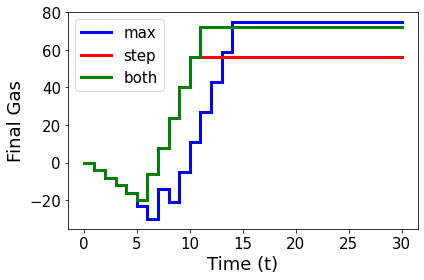

In [54]:
x_max,y_max = read_csv("max.csv")
x_step, y_step = read_csv("step.csv")
x_both, y_both = read_csv("both.csv")
plt.rcParams["figure.autolayout"] = True
for x, y, label, c in [(x_max, y_max, "max", "b"), (x_step, y_step, "step", "r"), (x_both, y_both, "both", "g")]:
    for i in range(len(x)):
        if i == len(x)-1:
            plt.plot(x[i],y[i], c = c, linewidth = 3, label = label)
        else:
            plt.plot(x[i],y[i], c = c, linewidth = 3)
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
plt.legend(fontsize = 15)
plt.savefig("simulation.png")
plt.xlabel("Time (t)",  fontsize=18)
plt.ylabel("Final Gas",  fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()